In [2]:
# Download the data
import shutil
import urllib.request as request
from contextlib import closing

# first we download the Sift1M dataset
with closing(request.urlopen('ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz')) as r:
    with open('/mnt/sda/vectors/sift.tar.gz', 'wb') as f:
        shutil.copyfileobj(r, f)

In [3]:
# Extract the data
import tarfile

# the download leaves us with a tar.gz file, we unzip it
tar = tarfile.open('/mnt/sda/vectors/sift.tar.gz', "r:gz")
tar.extractall()

In [4]:
import numpy as np

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

In [6]:
# 1M samples
xb = read_fvecs('/mnt/sda/vectors/sift/sift_base.fvecs')
# queries
xq_full = read_fvecs('/mnt/sda/vectors/sift/sift_query.fvecs')
xq = xq_full[0].reshape(1, -1)

print(xq_full.shape)
print(xq.shape)
print(xb.shape)

(10000, 128)
(1, 128)
(1000000, 128)


In [7]:
import faiss

# setup our HNSW parameters
d = 128  # vector size
M = 32
efSearch = 32  # number of entry points (neighbors) we use on each layer
efConstruction = 32  # number of entry points used on each layer during construction

index = faiss.IndexHNSWFlat(d, M)
print(index.hnsw)

<faiss.swigfaiss.HNSW; proxy of <Swig Object of type 'faiss::HNSW *' at 0x7fe7684e6fc0> >


In [8]:
# the HNSW index starts with no levels
print(index.hnsw.max_level)

# and levels (or layers) are empty too
levels = faiss.vector_to_array(index.hnsw.levels)
print(np.bincount(levels))

-1
[]


In [9]:
# If we go ahead and build the index, we’ll find that both of these parameters are now set.
index.add(xb)

# after adding our data we will find that the level has been set automatically
print(index.hnsw.max_level)

# and levels (or layers) are now populated
levels = faiss.vector_to_array(index.hnsw.levels)
print(np.bincount(levels))

# We can even find which vector has been selected as our entry point
print(index.hnsw.entry_point)

4
[     0 968746  30276    951     26      1]
118295


In [14]:
# That was a high-level view of our Faiss-flavored HNSW graph, but before we test the index, let’s dive a little deeper into
# how Faiss is building this structure.

# When we initialize our index we pass our vector dimensionality d and number of neighbors for each vertex M.
# This calls the method ‘set_default_probas’, passing M and 1 / log(M) in the place of levelMult (equivalent to m_L above).
# A Python equivalent of this method looks like:

def set_default_probas(M: int, m_L: float):
    nn = 0  # set nearest neighbors count = 0
    cum_nneighbor_per_level = []
    level = 0  # we start at level 0
    assign_probas = []
    while True:
        # calculate probability for current level
        proba = np.exp(-level / m_L) * (1 - np.exp(-1 / m_L))
        # once we reach low prob threshold, we've created enough levels
        if proba < 1e-9: break
        assign_probas.append(proba)
        # neighbors is == M on every level except level 0 where == M*2
        nn += M*2 if level == 0 else M
        cum_nneighbor_per_level.append(nn)
        level += 1
    return assign_probas, cum_nneighbor_per_level

# Here we are building two vectors — assign_probas: the probability of insertion at a given layer, and
# cum_nneighbor_per_level: the cumulative total of nearest neighbors assigned to a vertex at different insertion levels.
assign_probas, cum_nneighbor_per_level = set_default_probas(
    32, 1/np.log(32)
)
print(assign_probas, cum_nneighbor_per_level)

# From this, we can see the significantly higher probability of inserting a vector at level 0 than higher levels
# (although, as we will explain below, the probability is not exactly as defined here). This function means higher levels are more sparse,
# reducing the likelihood of ‘getting stuck’, and ensuring we start with longer range traversals.

# Our assign_probas vector is used by another method called random_level — it is in this function that each vertex is assigned an insertion level.

# this is copy of HNSW::random_level function
def random_level(assign_probas: list, rng):
    # get random float from 'r'andom 'n'umber 'g'enerator
    f = rng.uniform() 
    for level in range(len(assign_probas)):
        # if the random float is less than level probability...
        if f < assign_probas[level]:
            # ... we assert at this level
            return level
        # otherwise subtract level probability and try again
        f -= assign_probas[level]
    # below happens with very low probability
    return len(assign_probas) - 1

chosen_levels = []
rng = np.random.default_rng(12345)
for _ in range(1_000_000):
    chosen_levels.append(random_level(assign_probas, rng))
print(np.bincount(chosen_levels))

# We need a lot of vectors for any of them to be assigned to the top-level layer 5 - using our 1_000_000 sample size we actually don't return any 
# at this higher level, and in fact only return one vertex at level 4.

[0.96875, 0.030273437499999986, 0.0009460449218749991, 2.956390380859371e-05, 9.23871994018553e-07, 2.887099981307982e-08] [64, 96, 128, 160, 192, 224]
[968821  30170    985     23      1]


In [20]:
# If we wanted, we could increase the likelihood of insertion at higher layers by decreasing or increasing the level multiplier m_L,
# but the difference is minor, very random (probability could shift up/down), and also changes the calculated optimal number of layers,
# so it is not worth changing unless you have a specific reason for doing so - and changing this isn't supported in Faiss (at least from the Python wrapper).
# We can access the set_default_probas function as we will see below, but on modifying the values we will see no impact.


# First let's see what our current and expected values would be using our Python implementation, when using M == 32,
# Faiss will set m_L as 1/log(M), which leaves us with 0.2885:
print(1/np.log(32))

# Changing M and m_L using our Python implementation outputs:
set_default_probas(32, 0.09)

# Over in Faiss, we can view the population of each level using our 'default' implementation.
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

# Now let's try using index.hnsw.set_default_probas to change the level structure:
del index
index = faiss.IndexHNSWFlat(d, 32)
index.hnsw.set_default_probas(32, 0.09)  # HNSW::set_default_probas(int M, float levelMult)
index.hnsw.efConstruction = efConstruction
index.add(xb)

levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

# Finally, let's validate that m_L values ~0 produce a single layer HNSW graph (eg a NSW graph):
assign_probas, cum_nneighbor_per_level = set_default_probas(32, 0.0000001)
assign_probas, cum_nneighbor_per_level

chosen_levels = []
rng = np.random.default_rng(12345)
for _ in range(1_000_000):
    chosen_levels.append(random_level(assign_probas, rng))
    
np.bincount(chosen_levels)
del index

0.28853900817779266


In [28]:
# We've worked through a lot of the implementation detail in Faiss, let's now take a look at how different parameters can affect the performance of our index.
# We have two index construction parameters that can be modified, M and efConstruction.

recall_idx = []

index = faiss.IndexFlatL2(d)
index.add(xb)
D, recall_idx = index.search(xq_full[:1000], k = 1)

In [29]:
import os
def get_memory(filename, index):
    faiss.write_index(index, filename)
    file_size = os.path.getsize(filename)
    os.remove(filename)
    return file_size

In [ ]:
import pandas as pd
from tqdm.auto import trange
from datetime import datetime

dir_path = "/mnt/sda/vectors/perf/"

results = pd.DataFrame({
    'M': [],
    'efConstruction': [],
    'efSearch': [],
    'recall@1': [],
    'build_time': [],
    'search_time': [],
    'memory_usage': []
})

for epoch in range(3):
    for M_bit in range(1, 10):
        M = 2 ** M_bit
        print(M)
        for ef_bit in trange(1, 6):
            efConstruction = 2 ** ef_bit
            index = faiss.IndexHNSWFlat(d, M)
            index.efConstruction = efConstruction
            start = datetime.now()
            index.add(xb)
            build_time = (datetime.now() - start).microseconds
            memory_usage = get_memory(dir_path + "temp.index", index)
            for efSearch in [2, 4, 8, 16, 32]:
                index.efSearch = efSearch
                start = datetime.now()
                D, I = index.search(xq_full[:1000], k = 1)
                search_time = (datetime.now() - start).microseconds
                recall = sum(I == recall_idx)[0]
                results = results.append({
                    'M': M,
                    'efConstruction': efConstruction,
                    'efSearch': efSearch,
                    'recall@1': recall,
                    'build_time': build_time,
                    'search_time': search_time,
                    'memory_usage': memory_usage
                }, ignore_index = True)
            del index
results.to_csv(dir_path + "results.csv", sep = '|', index = False)
print("Done")

In [8]:
import pandas as pd
dir_path = "/mnt/sda/vectors/perf/"
results = pd.read_csv(dir_path + "results.csv", sep = '|')
results.head()

,M,efConstruction,efSearch,recall@1,build_time,search_time,memory_usage
0,2.0,2.0,2.0,102.0,145997.0,7420.0,547995894.0
1,2.0,2.0,4.0,102.0,145997.0,11735.0,547995894.0
2,2.0,2.0,8.0,102.0,145997.0,10969.0,547995894.0
3,2.0,2.0,16.0,102.0,145997.0,11674.0,547995894.0
4,2.0,2.0,32.0,102.0,145997.0,10876.0,547995894.0


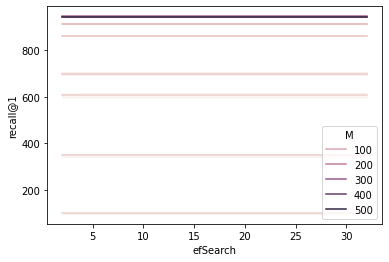

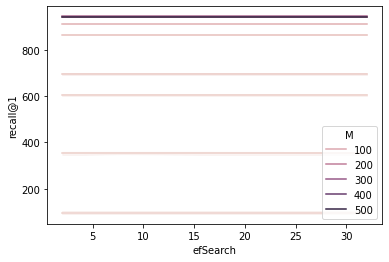

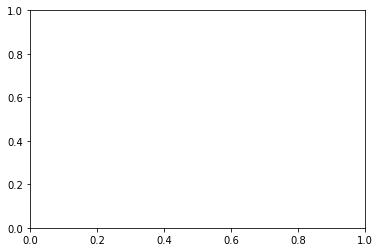

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for efConstruction in [2, 16, 64]:
    sns.lineplot(data = results[results['efConstruction'] == efConstruction], x = 'efSearch', y = 'recall@1', hue = 'M')
    plt.show()

/tmp/ipykernel_1060327/3040753812.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 500_000)


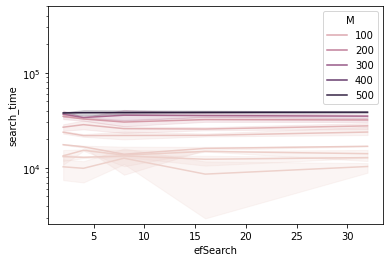

/tmp/ipykernel_1060327/3040753812.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 500_000)


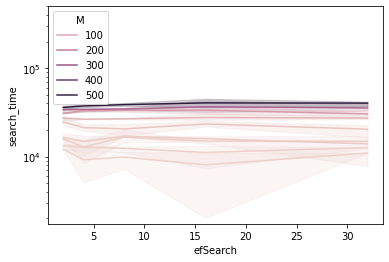

/tmp/ipykernel_1060327/3040753812.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 500_000)


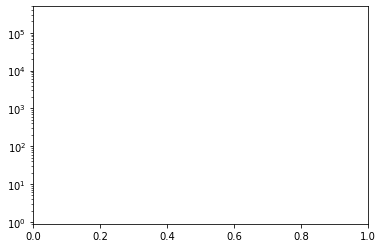

In [10]:
for efConstruction in [2, 16, 64]:
    sns.lineplot(data = results[results['efConstruction'] == efConstruction], x = 'efSearch', y = 'search_time', hue = 'M')
    plt.yscale('log')
    plt.ylim(0, 500_000)
    plt.show()

<AxesSubplot:xlabel='M', ylabel='memory_usage'>

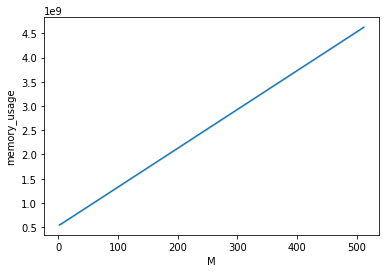

In [11]:
sns.lineplot(data = results, x = 'M', y = 'memory_usage')